<a href="https://colab.research.google.com/github/Andres8bit/Machine-Learning/blob/main/275_Bird_Challenge_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import os
import pandas as pd
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
from keras.utils import np_utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# Load in VGG16 with ImageNet Weights without the top_layer/classifier:
base_model = VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3))

In [53]:
# Dataset Download:
base_path = "/content/drive/MyDrive/bird Species.zip (Unzipped Files)"
train_path = os.path.join(base_path,'train')
test_path = os.path.join(base_path,'test')
validation_path = os.path.join(base_path,'valid')

In [54]:
def decay(epochs,steps=100):
  init_learning_rate = 0.01
  drop = 0.96
  epochs_drop = 8
  learning_rate = init_learning_rate * math.pow(drop,math.floor((1+epochs)/epochs_drop))
  return learning_rate

In [55]:
def display_loss(model):
  loss = model.history['loss']
  val_loss = model.history['val_loss']

  plt.figure()
  plt.plot(model.epoch, loss, 'r',label='Training loss')
  plt.plot(model.epoch,val_loss,'bo',label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss Value')
  plt.ylim([0,1])
  plt.legend()

In [56]:
csv_path = r'/content/drive/MyDrive/bird Species.zip (Unzipped Files)/birds.csv'
df=pd.read_csv(csv_path, index_col=0)
classes= list(df['labels'].unique())
class_count=len(classes)
nf=[]
for f in df['filepaths']:
    nf.append(f.replace('\\', '/'))# replace \'s with /'s in df column filepaths
nfseries=pd.Series(nf, name='nf')
df['filepaths']=nfseries
print (df.head())

                             filepaths                 labels data set
0  train/AFRICAN CROWNED CRANE/001.jpg  AFRICAN CROWNED CRANE    train
1  train/AFRICAN CROWNED CRANE/002.jpg  AFRICAN CROWNED CRANE    train
2  train/AFRICAN CROWNED CRANE/003.jpg  AFRICAN CROWNED CRANE    train
3  train/AFRICAN CROWNED CRANE/004.jpg  AFRICAN CROWNED CRANE    train
4  train/AFRICAN CROWNED CRANE/005.jpg  AFRICAN CROWNED CRANE    train


In [57]:
# Load Datasets to Tensorflow Dataset:
training_set = image_dataset_from_directory(directory=train_path,labels='inferred'
                                    ,label_mode='categorical', class_names=None,
                                    color_mode='rgb', batch_size=16,
                                    image_size=(224, 224),shuffle=True)
test_set = image_dataset_from_directory(test_path,labels='inferred',
                                    label_mode='categorical',class_names=None,
                                    color_mode='rgb',batch_size=16,shuffle=True
                                    ,image_size=(224,224))
valid_set = image_dataset_from_directory(validation_path,labels='inferred',
                                    label_mode='categorical',class_names=None,
                                    color_mode='rgb',shuffle=True,batch_size=16,
                                    image_size=(224,224))

Found 39364 files belonging to 275 classes.
Found 1375 files belonging to 275 classes.
Found 1375 files belonging to 275 classes.


In [58]:
# Buffered Prefetching for better performance by overlaping model execution and data preprocessing:
AUTOTUNE = tf.data.AUTOTUNE

training_set = training_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)
valid_set = valid_set.cache().prefetch(buffer_size=AUTOTUNE)

In [59]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

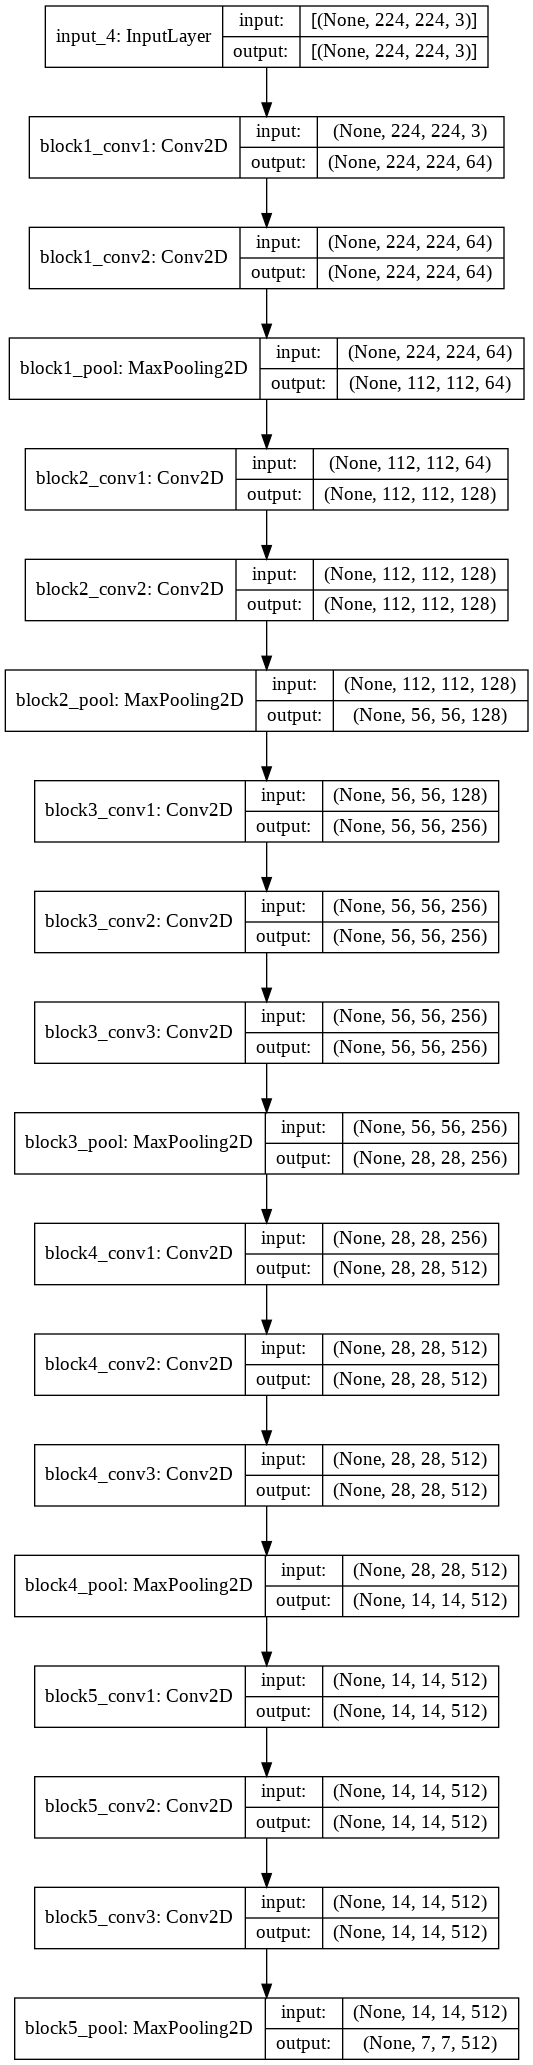

In [60]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [61]:
# Freeze layers to avoid re-training:
for layer  in base_model.layers[:-1 ]:
  layer.trainable = False;

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [62]:
# New Classification Layer for our dataset:
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

x = Flatten()(last_output)
x = Dense(275,activation='softmax',name='softmax')(x)

In [63]:
new_model = Model(inputs=base_model.input,outputs=x)

new_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [64]:
learning_rate_scheduler = LearningRateScheduler(decay,verbose=1)
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5',verbose=1,save_best_only=True)
callbacks =[checkpointer,learning_rate_scheduler]

In [65]:
new_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = new_model.fit(training_set,
                              epochs = 50,
                              validation_data = valid_set,
                              verbose = 1,
                              steps_per_epoch=8,
                              callbacks = callbacks)

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
8/8 [==============================] - 776s 106s/step - loss: 439.2223 - accuracy: 0.0070 - val_loss: 960.7511 - val_accuracy: 0.0444

Epoch 00001: val_loss improved from inf to 960.75110, saving model to model.weights.best.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
8/8 [==============================] - 743s 105s/step - loss: 901.7999 - accuracy: 0.0295 - val_loss: 1191.5919 - val_accuracy: 0.0611

Epoch 00002: val_loss did not improve from 960.75110
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
8/8 [==============================] - ETA: 0s - loss: 1239.8580 - accuracy: 0.0554

In [ ]:
print('\nTesting loss: {:.4f}\nTesting Accuracy:{:.4f}'.format(*new_model.evaluate(test_set)))

In [ ]:
# Confusion Matrix:
from sklearn.metrics import confusion_matrix
import numpy as np

class_labels = test_set.class_names 

confusion = confusion_matrix(np.armax(class_labels,axis=1),np.argmax(new_model.predict(test_set),axis=1))

plt.imshow(confusion,cmp=plt.cm.Blues)
plt.colobar()
indexes = np.arange(len(class_labels))

for i in indexes:
  for j in indexes:
    plt.test(j,i,confusion[i,j])

plt.xticks(indexes,class_labels,rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes,class_labels)
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()